In [265]:
import pathlib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import patsy

from scipy.stats import boxcox 

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [254]:
cwd = pathlib.Path.cwd()
data_path = cwd / 'data'
pkl_path = data_path / 'pkl'
observations_pkl = pkl_path /'observations.pkl'

df = pd.read_pickle(observations_pkl).astype(float)
df['Percent_Passed'] = df['Percentage_Standard_Met_and_Above']
df['Math'] = df['Test_Id'] - 1
df['Mean_Score'] = df['Mean_Scale_Score']
df['Percent_Tested'] = df['Students_Tested'] / df['CAASPP_Reported_Enrollment']
df['Participation_95'] = (df['Percent_Tested'] > 0.95).astype(int)
df = df[['Median_Income', 'Percent_Passed', 'Math', 'Participation_95', 'Percent_Tested', 'Grade', 'Mean_Score']]
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 56928 entries, (1, 10017, 112607) to (58, 72769, 5838305)
Data columns (total 7 columns):
Median_Income       56928 non-null float64
Percent_Passed      56928 non-null float64
Math                56928 non-null float64
Participation_95    56928 non-null int64
Percent_Tested      56928 non-null float64
Grade               56928 non-null float64
Mean_Score          56928 non-null float64
dtypes: float64(6), int64(1)
memory usage: 3.8 MB


(array([2104., 3421., 6252., 8324., 8976., 8484., 7456., 6120., 4447.,
        1344.]),
 array([0.        , 0.06931472, 0.13862944, 0.20794415, 0.27725887,
        0.34657359, 0.41588831, 0.48520303, 0.55451774, 0.62383246,
        0.69314718]),
 <a list of 10 Patch objects>)

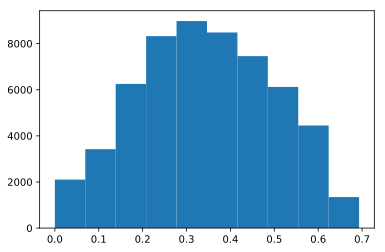

In [259]:
plt.hist(np.log(df.Percent_Passed+1))
# plt.hist(df.Percent_Passed)

(array([11377.,     0., 11416., 11436.,     0.,  8195.,  5169.,  5177.,
            0.,  4158.]),
 array([1.09861229, 1.22854059, 1.35846889, 1.48839718, 1.61832548,
        1.74825378, 1.87818208, 2.00811038, 2.13803868, 2.26796697,
        2.39789527]),
 <a list of 10 Patch objects>)

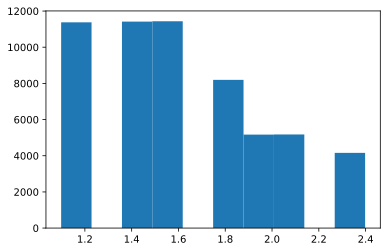

In [261]:
# plt.hist(df.Grade)
plt.hist(np.log(df.Grade))

In [285]:
#: Old -- changed to 95% participation rate

# plt.hist(df.Percent_Tested)
# plt.hist(np.power(df.Percent_Tested, 10))
# plt.hist(np.log(1.01-df.Percent_Tested))
# plt.hist(boxcox(1.01-df.Percent_Tested))
bc, _ = boxcox(1.01-df.Percent_Tested)
df['BoxCox'] = bc

In [277]:
boxcox(1.01-df.Percent_Tested)

(array([ -8.89884555,  -8.89884555,  -6.97023285, ..., -16.50445292,
        -10.72396357,  -7.56835558]), -0.47199485355854454)

In [301]:
y, X = patsy.dmatrices('Median_Income ~ Math * np.log(Grade) * Mean_Score * np.log(Percent_Passed + 1)'
#                        + ' + Participation_95 + 0',
#                        + ' + BoxCox + 0',
                      + ' + np.log(1.01-Percent_Tested) + 0',
#                       + '+ np.power(Percent_Tested, 10) + 0', 
                       data=df)

linreg = LinearRegression()
fit = linreg.fit(X, y)
r_squared = linreg.score(X, y)
adjusted_r_squared = 1 - (1 - r_squared) * len(y) / (len(y) - X.shape[1] - 1)
rmse = np.sqrt(mean_squared_error(y, fit.predict(X)))

# print('Coefficients:', fit.coef_)
print('Intercept:', fit.intercept_)
print('R^2 Score:', r_squared)
print('Adj R^2 Score:', adjusted_r_squared)
print('RMSE Score:', rmse)

Intercept: [473036.02174723]
R^2 Score: 0.3585455001500233
Adj R^2 Score: 0.3583538899780452
RMSE Score: 19598.10857288548


Intercept: [485101.10596471]
R^2 Score: 0.3584980361309097
Adj R^2 Score: 0.3583064117808583
RMSE Score: 19598.833634283652

In [209]:
X.design_info.column_names

['Math',
 'np.log(Grade)',
 'Math:np.log(Grade)',
 'Mean_Score',
 'Math:Mean_Score',
 'np.log(Grade):Mean_Score',
 'Math:np.log(Grade):Mean_Score',
 'np.log(Percent_Passed + 1)',
 'Math:np.log(Percent_Passed + 1)',
 'np.log(Grade):np.log(Percent_Passed + 1)',
 'Math:np.log(Grade):np.log(Percent_Passed + 1)',
 'Mean_Score:np.log(Percent_Passed + 1)',
 'Math:Mean_Score:np.log(Percent_Passed + 1)',
 'np.log(Grade):Mean_Score:np.log(Percent_Passed + 1)',
 'Math:np.log(Grade):Mean_Score:np.log(Percent_Passed + 1)',
 'Participation_95']

In [272]:
# import statsmodels.api as sm

# lm = sm.OLS(y, sm.add_constant(X))
# fit = lm.fit()
# fit.summary()

In [162]:
y_df = pd.DataFrame(y, columns=y.design_info.column_names)
X_df = pd.DataFrame(X, columns=X.design_info.column_names)
interactions = pd.concat([y_df, X_df], axis=1)

In [39]:
# sns.heatmap(interactions.corr(), annot=True);

In [281]:
# sns.pairplot(interactions);

In [38]:
#: For sklearn fit

# predictions = fit.predict(X)
# residuals = y - fit.predict(X)
# plt.scatter(x=predictions, y=residuals, alpha=0.2);

In [286]:
#: For statsmodels fit

# plt.scatter(fit.resid)

In [302]:
# split into Train 60%, Validate 20%, Test 20%
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.25, random_state=10)

# Cross Fold Validation (80-20) (Train, Test)

In [306]:
X_arr, y_arr = np.array(X_), np.array(y_)

kfold = KFold(n_splits=5, shuffle=True, random_state=10)
cv_lm_adj_r2, cv_ridge_adj_r2, cv_lasso_adj_r2, cv_poly_adj_r2 = [], [], [], []
cv_lm_rmse, cv_ridge_rmse, cv_lasso_rmse, cv_poly_rmse = [], [], [], []

for train_idx, valid_idx in kfold.split(X_arr, y_arr):
    X_train, y_train = X_arr[train_idx], y_arr[train_idx]
    X_valid, y_valid = X_arr[valid_idx], y_arr[valid_idx]
    
    lm = LinearRegression()
    fit = lm.fit(X_train, y_train)
    r2 = lm.score(X_valid, y_valid)
    adj_r2 = 1 - (1 - r2) * len(y_valid) / (len(y_valid) - X_valid.shape[1] - 1)
    cv_lm_adj_r2.append(adj_r2)
    rmse = np.sqrt(mean_squared_error(y_valid, fit.predict(X_valid)))
    cv_lm_rmse.append(rmse)
    
    scaler = StandardScaler()
    X_train_scale = scaler.fit_transform(X_train)
    X_valid_scale = scaler.transform(X_valid)

#     lm_ridge = Ridge()
#     lm_ridge.fit(X_train_scale, y_train)
#     r2 = lm_ridge.score(X_valid_scale, y_valid)
#     adj_r2 = 1 - (1 - r2) * len(y_valid) / (len(y_valid) - X_valid_scale.shape[1] - 1)
#     cv_ridge_adj_r2.append(adj_r2)
#     rmse = np.sqrt(mean_squared_error(y_valid, fit.predict(X_valid_scale)))
#     cv_ridge_rmse.append(rmse)
    
    #: Convergence Warnings
#     lm_lasso = Lasso()
#     lm_lasso.fit(X_train_scale, y_train)
#     r2 = lm_lasso.score(X_valid_scale, y_valid)
#     adj_r2 = 1 - (1 - r2) * len(y_valid) / (len(y_valid) - X_valid_scale.shape[1] - 1)
#     cv_lasso_adj_r2.append(adj_r2)
#     rmse = np.sqrt(mean_squared_error(y_valid, fit.predict(X_valid_scale)))
#     cv_lasso_rmse.append(rmse)
    
    
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)
    X_valid_poly = poly.transform(X_valid)
    
    lm_poly = LinearRegression()
    fit_poly = lm_poly.fit(X_train_poly, y_train)
    r2 = lm_poly.score(X_valid_poly, y_valid)
    adj_r2 = 1 - (1 - r2) * len(y_valid) / (len(y_valid) - X_valid_poly.shape[1] - 1)
    cv_poly_adj_r2.append(adj_r2)
    rmse = np.sqrt(mean_squared_error(y_valid, fit_poly.predict(X_valid_poly)))
    cv_poly_rmse.append(rmse)

In [304]:
np.mean(cv_lm_adj_r2), np.mean(cv_lm_rmse)

(0.35643572186692085, 19582.797365181617)

In [307]:
np.mean(cv_ridge_adj_r2), np.mean(cv_ridge_rmse)

(0.3540319608877012, 1783233.7728457288)

In [251]:
np.mean(cv_lasso_adj_r2), np.mean(cv_lasso_rmse)

(0.34256407735204586, 1783233.7728457288)

In [305]:
np.mean(cv_poly_adj_r2), np.mean(cv_poly_rmse)

(0.3518629861273557, 19503.482853555168)

In [ ]:
(0.35633963453596723, 19584.269152801142)
(0.3534548123994733, 19479.480413910493)